# Sprint 8: Proyecto - Análisis de Negocio

-   [Introducción](#introducción)
-   [Importar bibliotecas](#importar-bibliotecas)
-   [Cargar datos](#cargar-datos)
-   [Informes y cálculo de métricas](#informes-y-cálculo-de-métricas)
    -   [Visitas](#visitas)
        -   [Actividad del usuario](#actividad-del-usuario)
        -   [Factor de aherencia](#factor-de-adherencia)
    -   [Ventas](#ventas)
        -   [Tasa de conversióon](#tasa-de-conversión)
        -   [Pedidos mensuales](#pedidos-mensuales)
        -   [Tamaño promedio por compra en USD](#tamaño-promedio-por-compra-en-usd)
        -   [Economía unitaria por cliente: LTV](#economía-unitaria-por-cliente-ltv)
    -   [Marketing](#marketing)
        -   [Gastos generales en marketing](#gastos-generales-en-marketing)
        -   [Gastos por fuente de adquisición](#gastos-por-fuente-de-adquisición)
        -   [Economía unitaria por cliente: CAC](#economía-unitaria-por-cliente-cac)
        -   [Economía unitaria por cliente: ROMI](#economía-unitaria-por-cliente-romi)
-   [Conclusiones](#conclusiones)

## Introducción

Se te ha ido muy bien en el curso TripleTen y te han ofrecido hacer prácticas en el departamento analítico de Y.Afisha. Tu primera tarea es ayudar a optimizar los gastos de marketing.

Lo que tienes:

* registros del servidor con datos sobre las visitas a Y.Afisha desde enero de 2017 hasta diciembre de 2018;
* un archivo con los pedidos en este periodo;
* estadísticas de gastos de marketing.

Lo que vas a investigar:

* cómo los clientes usan el servicio;
* cuándo empiezan a comprar;
* cuánto dinero aporta cada cliente a la compañía;
* cuándo los ingresos cubren el costo de adquisición de los clientes.

Instrucciones para completar el proyecto:

Paso 1. Descarga los datos y prepáralos para el análisis

Almacena los datos de visitas, pedidos y gastos en variables.  Optimiza los datos para el análisis. Asegúrate de que cada columna contenga el tipo de datos correcto.

Rutas de archivos: 

`/datasets/visits_log_us.csv. Descarga el dataset`

`/datasets/orders_log_us.csv. Descarga el dataset`

`/datasets/costs_us.csv. Descarga el dataset`

Paso 2. Haz informes y calcula métricas 

1. Visitas:
    * ¿Cuántas personas lo usan cada día, semana y mes?
    * ¿Cuántas sesiones hay por día? (Un/a usuario/a puede tener más de una sesión).
    * ¿Cuál es la duración de cada sesión?
    * ¿Con qué frecuencia los usuarios y las usuarias regresan?

2. Ventas:
 
    * ¿Cuándo la gente empieza a comprar? (En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el/la usuario/a se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el/la usuario/a podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d.  Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo).
    * ¿Cuántos pedidos hacen durante un período de tiempo dado?
    * ¿Cuál es el tamaño promedio de compra?
    * ¿Cuánto dinero traen? (LTV)

3. Marketing:
 
    * ¿Cuánto dinero se gastó? (Total/por fuente de adquisición/a lo largo del tiempo)
    * ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
    * ¿Cuán rentables eran las inversiones? (ROMI)

Traza gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo. 

## Importar bibliotecas

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from IPython.display import Image, display


## Cargar datos

Se creó una función para cargar los datos de los archivos CSV ya que se llamará en más de una ocasión a lo largo del código.

In [2]:
def data_load():	
    costs_dl = pd.read_csv(
	    'costs_us.csv', 
	    dtype={'source_id': 'category'}, 
	    parse_dates=['dt'], 
	    # nrows=500
	    )
    #
    orders_dl = pd.read_csv(
	    'orders_log_us.csv',
	    parse_dates = ['Buy Ts'],
	    # nrows = 500
	)
    orders_dl.columns = ['buy_ts', 'revenue', 'uid']
    #
    visits_dl = pd.read_csv(
	    'visits_log_us.csv',
	    dtype={'Device': 'category', 'Source Id': 'int'}, 
	    parse_dates = ['End Ts', 'Start Ts'],
	    # nrows = 500
	)
    visits_dl.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
    return costs_dl, orders_dl, visits_dl

In [3]:
# costs_us = pd.read_csv(
#     'costs_us.csv', 
#     dtype={'source_id': 'category'}, 
#     parse_dates=['dt'], 
#     # nrows=500
#     )

# costs_us.info(memory_usage='deep')

In [4]:
# orders = pd.read_csv(
#     'orders_log_us.csv',
#     parse_dates = ['Buy Ts'],
#     # nrows = 500
# )

# orders.columns = ['buy_ts', 'revenue', 'uid']
# orders.info(memory_usage = 'deep')

In [5]:
# visits = pd.read_csv(
#     'visits_log_us.csv',
#     dtype={'Device': 'category', 'Source Id': 'int'}, 
#     parse_dates = ['End Ts', 'Start Ts'],
#     # nrows = 500
# )

# visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
# visits.info(memory_usage = 'deep')

In [6]:
[costs_us, orders, visits] = data_load()

In [7]:
#Buscando duplicados
print(costs_us.duplicated().unique())
print(orders.duplicated().unique())
print(visits.duplicated().unique())

[False]
[False]
[False]


## Informes y cálculo de métricas 

### Visitas

####    Actividad del usuario

Hay tres métricas principales que describen el número de usuarios activos:

*   DAU (usuarios activos diarios): el número de usuarios activos diarios (únicos).
*   WAU (usuarios activos semanales): el número de usuarios activos semanales.
*   MAU (usuarios activos mensuales): el número de usuarios activos mensuales.

In [8]:
visits['session_year']  = visits['start_ts'].dt.isocalendar().year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_date'] = visits['start_ts'].dt.date
# print(visits.head())

In [9]:
mau_total = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)

wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

dau_total = (
    visits.groupby(['session_date'])
    .agg({'uid': 'nunique'})
    .mean()
)

In [10]:
print(f'----------------------------------------\n',
      'DAU (usuarios activos diarios): ', dau_total.astype('int').iloc[0],
      '\n----------------------------------------\n',
      '\nWAU (usuarios activos semanales): ', wau_total.iloc[0].astype('int'), 
      '\n----------------------------------------\n',
      '\nMAU (usuarios activos mensuales): ', mau_total.iloc[0].astype('int'),
      '\n----------------------------------------',)

----------------------------------------
 DAU (usuarios activos diarios):  907 
----------------------------------------
 
WAU (usuarios activos semanales):  5716 
----------------------------------------
 
MAU (usuarios activos mensuales):  23228 
----------------------------------------


In [11]:
daily_sessions = visits.groupby('session_date').agg({'uid': ['count', 'nunique']})
daily_sessions.columns = ['n_sessions', 'n_users']

daily_sessions_mean = daily_sessions['n_sessions'].mean()

print('Sesiones diarias:')
print(daily_sessions.head())
print(f'\n--------------------------------\n',
      'Sesiones dirias promedio: ', 
      int(daily_sessions_mean),
      '\n--------------------------------',)

Sesiones diarias:
              n_sessions  n_users
session_date                     
2017-06-01           664      605
2017-06-02           658      608
2017-06-03           477      445
2017-06-04           510      476
2017-06-05           893      820

--------------------------------
 Sesiones dirias promedio:  987 
--------------------------------


In [12]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts'])#.dt.seconds
visits['session_duration_sec'] = (visits['session_duration_sec'] / np.timedelta64(1, 'm'))
# visits.head()
# visits.info()
# visits['session_duration_sec'] = visits['session_duration_sec'] / np.timedelta64(1, 'm')
print(f'Duración promedio de las sesiones :{visits['session_duration_sec'].mean():,.2f}', 'minutos')

Duración promedio de las sesiones :10.72 minutos


Las métricas de actividad de los usuarios de la empresa muestran un comportamiento consistente y saludable en su base de usuarios activos, con niveles significativos de participación diaria, semanal y mensual.

1. DAU (Usuarios Activos Diarios): Con 907 usuarios activos diariamente, la empresa demuestra una buena retención diaria, lo que sugiere que una proporción sólida de usuarios encuentra valor en los servicios y los utiliza de manera frecuente.

2. WAU (Usuarios Activos Semanales): El número de usuarios activos semanales es de 5716, lo que indica que una mayor cantidad de usuarios se involucra con los servicios a lo largo de la semana, posiblemente reflejando patrones de uso que varían según días específicos o necesidades semanales.

3. MAU (Usuarios Activos Mensuales): Con 23,228 usuarios activos mensuales, la empresa tiene una base de usuarios considerable que interactúa con los servicios al menos una vez al mes. Este número, comparado con los DAU y WAU, sugiere que la mayoría de los usuarios son más esporádicos en su uso, aunque la base diaria sigue siendo robusta.

4. Sesiones Diarias:

    *   Las sesiones diarias registradas oscilan entre 477 y 893 en el periodo dado, con un promedio de 987 sesiones diarias. Esto sugiere que la actividad del usuario es estable, aunque podría haber días específicos con menor o mayor actividad.
    *   Relación entre DAU y Sesiones Diarias: Dado que el número de sesiones es similar al número de usuarios activos diarios, esto indica que los usuarios suelen realizar aproximadamente una sesión por día, lo que podría reflejar un hábito de uso específico o un patrón de interacción breve y eficaz.

5. Duración Promedio de las Sesiones: Con una duración promedio de 10.72 minutos por sesión, los usuarios parecen estar dedicando un tiempo razonable a cada sesión, lo que sugiere que el contenido o los servicios ofrecidos mantienen el interés durante un periodo suficientemente largo como para ser efectivos en cumplir sus objetivos.

#### Factor de adherencia

Esta métrica te dice qué tan leal es la audiencia, con qué frecuencia regresan a la aplicación. La fórmula es simple: 
*   Semanal
$$
sticky factor = DAU/WAU
$$
*   Mensual
$$
sticky factor = DAU/MAU
$$

<div class="alert alert-block alert-info">
<b>Nota:</b> No entendí a que se refieren con la prgunta `¿Con qué frecuencia los usuarios y las usuarias regresan?`. Creo que se refiere al `factor de adherencia`, pero, también obtuve el porcentaje de usuarios que regresan a la aplicación, el porcetaje de ususarios que vuelve a hacer un pedido. <a class="tocSkip"></a>

In [13]:
aux = visits.groupby(['uid']).agg({'uid' : 'count'})
clients = aux[aux > 1].dropna()

# aux.info()
print('\n--------------------------------------------------------------------\n')
# clients.info()

print(f'\n\n -----------------------------------------------------------------------\n', 
      '| El ', int(len(clients)/len(aux)*100), 
      '% de los usuarios regresan a la aplicación al menos una vez. |',
      '\n -----------------------------------------------------------------------'
      )


--------------------------------------------------------------------



 -----------------------------------------------------------------------
 | El  22 % de los usuarios regresan a la aplicación al menos una vez. | 
 -----------------------------------------------------------------------


In [14]:
aux = orders.groupby(['uid']).agg({'uid' : 'count'})
client_series = aux[aux > 1].dropna()

# aux.info()
print('\n--------------------------------------------------------------------\n')
# client_series.info()

print(f'\n\n ----------------------------------------------------\n', 
      '| El ', int(len(client_series)/len(aux)*100), 
      '% de los usuarios hacen más de una orden. |',
      '\n ----------------------------------------------------'
      )


--------------------------------------------------------------------



 ----------------------------------------------------
 | El  17 % de los usuarios hacen más de una orden. | 
 ----------------------------------------------------


In [15]:
sticky_wau = (dau_total/wau_total) * 100
print(f'Factor de adherencia: ', sticky_wau.astype('int').iloc[0])

Factor de adherencia:  15


Las métricas proporcionadas reflejan la capacidad de la empresa para atraer y retener usuarios, así como su efectividad en fomentar comportamientos de compra repetitiva. Aquí se presenta un análisis de los datos:

1. Retención de Usuarios:

    Solo el 22% de los usuarios regresan a la aplicación al menos una vez. Esta baja tasa de retención indica que la mayoría de los usuarios no encuentran suficiente valor o incentivo para volver a utilizar el servicio después de su primera interacción. Esto podría sugerir la necesidad de mejorar la experiencia de usuario, el contenido, o las estrategias de re-engagement.

2. Comportamiento de Compra:

    El 17% de los usuarios realizan más de una orden. Aunque este porcentaje es cercano al de retención, muestra que un número aún menor de usuarios se convierte en clientes recurrentes. Esto podría estar relacionado con la calidad del servicio, la satisfacción del cliente, o la oferta de productos. Mejorar las ofertas promocionales o programas de lealtad podría aumentar esta cifra.

3. Factor de Adherencia:

    Un factor de adherencia de 15 sugiere que aquellos usuarios que permanecen y realizan compras tienden a hacerlo con relativa frecuencia. Este es un punto positivo que indica que, aunque la base de usuarios recurrentes es pequeña, aquellos que se mantienen comprometidos muestran un alto nivel de interacción con el servicio.

### Ventas

#### Tasa de conversión

In [16]:
clients = visits.merge(orders, on= 'uid', how = 'right')
print(len(clients), len(visits), len(orders))
# print(clients.head(10))

761807 359400 50415


In [17]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761807 entries, 0 to 761806
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   device                761807 non-null  category      
 1   end_ts                761807 non-null  datetime64[ns]
 2   source_id             761807 non-null  int32         
 3   start_ts              761807 non-null  datetime64[ns]
 4   uid                   761807 non-null  uint64        
 5   session_year          761807 non-null  UInt32        
 6   session_month         761807 non-null  int32         
 7   session_week          761807 non-null  UInt32        
 8   session_date          761807 non-null  object        
 9   session_duration_sec  761807 non-null  float64       
 10  buy_ts                761807 non-null  datetime64[ns]
 11  revenue               761807 non-null  float64       
dtypes: UInt32(2), category(1), datetime64[ns](3), float64(2), 

In [18]:
first_activity_date = clients.groupby(['uid'])['start_ts'].min().dt.date
first_activity_date.name = 'first_activity_date'
clients = clients.join(first_activity_date, on='uid')

In [19]:
first_buy_date = clients.groupby(['uid'])['buy_ts'].min().dt.date
first_buy_date.name = 'first_buy_date'
clients = clients.join(first_buy_date, on='uid')

In [20]:
# clients.info()
print(clients[['first_activity_date','source_id', 'first_buy_date']].sample(5, random_state= 4123))

       first_activity_date  source_id first_buy_date
734881          2017-06-01          1     2017-06-05
454386          2017-11-24          1     2017-12-11
414772          2017-11-22          3     2018-01-05
142804          2017-08-29          2     2017-08-30
53846           2017-06-01          1     2017-06-05


In [21]:
clients_cohort = clients[['uid', 'device', 'source_id', 'first_activity_date', 'first_buy_date']]

print(f'-----------------------------------------\n',
      '\tDuplicated rows:',
      len(clients_cohort[clients_cohort.duplicated()]),
      '\n-----------------------------------------\n'
      )

clients_cohort = clients_cohort.drop_duplicates()
clients_cohort['first_buy_date'] = pd.to_datetime(clients_cohort['first_buy_date'])
clients_cohort['first_activity_date'] = pd.to_datetime(clients_cohort['first_activity_date'])
# clients_cohort['conversion'] = pd.to_datetime(clients_cohort['first_buy_date'].dt.date) - pd.to_timedelta(clients_cohort['first_activity_date'].dt.date)
clients_cohort['conversion'] = (clients_cohort['first_buy_date'] - clients_cohort['first_activity_date']).dt.days

# clients_cohort.info()
# print(clients_cohort.head())
# print(clients_cohort.sample(5, random_state= 4123))
print(clients_cohort['conversion'].nunique())
# print(clients_cohort['conversion'].value_counts().head(20))
print(clients_cohort['source_id'].unique())

-----------------------------------------
 	Duplicated rows: 702634 
-----------------------------------------

349
[ 1  2  3  5  4  9 10  7]


In [22]:
source_conversion = []
for source in clients_cohort['source_id'].unique():
    source_conversion.append(
        len(clients_cohort[clients_cohort['source_id'] == source])
    )

# print(clients_cohort['source_id'].unique())
# print(source_conversion)

In [23]:
# source_conversion = dict(zip(clients_cohort['source_id'].unique(), source_conversion))
# print(source_conversion)
source_conversion = pd.DataFrame({
    'source_id': clients_cohort['source_id'].unique(),
    'conversion_count': source_conversion
}).sort_values('conversion_count', ascending= False).reset_index(drop=True)

print(source_conversion)


   source_id  conversion_count
0          4             14807
1          3             14363
2          5             10350
3          2              7640
4          1              7311
5          9              2891
6         10              1810
7          7                 1


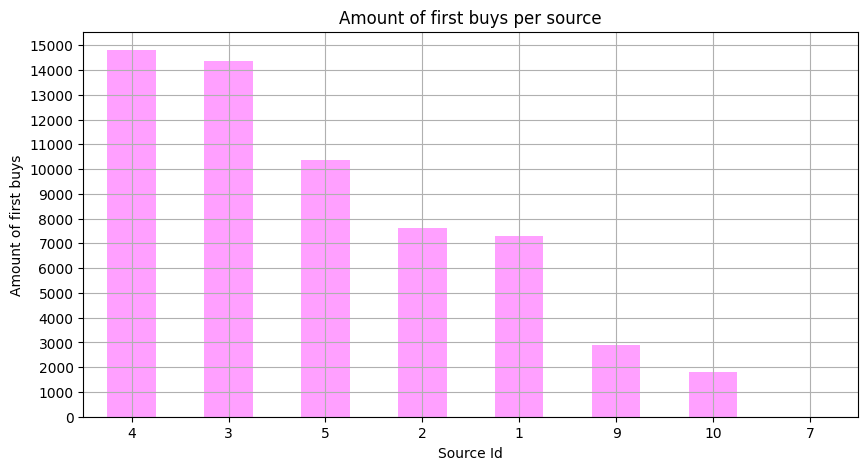

In [24]:
source_conversion.plot(
    x='source_id',
    y= 'conversion_count',
    kind='bar',
    figsize=[10,5],
    grid=True,
    color = '#FFA0FF',
    yticks = np.linspace(0, 15000, 16),
    title = 'Amount of first buys per source',
    ylabel = 'Amount of first buys',
    xlabel = 'Source Id',
    legend = False
    )

# plt.legend()
plt.xticks(rotation= 0)
plt.show()

In [25]:
def switch(case):
    if case == 0:
        return '0'
    elif case == 1:
        return '1'
    elif case == 2:
        return '2'
    elif case == 3:
        return '3'
    elif case == 4:
        return '4'
    elif case == 5:
        return '5'
    elif case == 6:
        return '6'
    elif case == 7:
        return '7'
    else:
        return '7+'

conversion = []

for conv in clients_cohort['conversion']:
    conversion.append(switch(conv))

print(len(conversion))
print(len(clients_cohort))

59173
59173


In [26]:
clients_cohort['conversion'] = conversion
# print(clients_cohort.sample(10))
# print(clients_cohort['conversion'].nunique())
print(clients_cohort['conversion'].value_counts())

conversion
0     34099
7+    16633
1      3657
2      1393
3       864
4       816
5       636
6       572
7       503
Name: count, dtype: int64


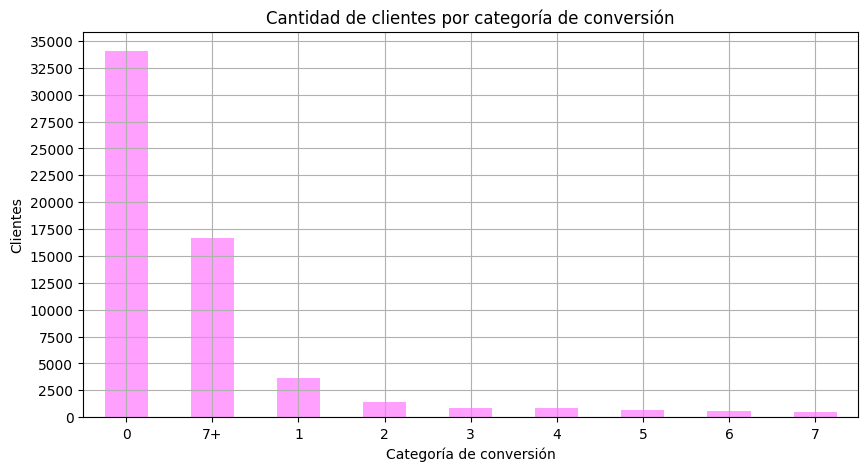

In [27]:
clients_cohort['conversion'].value_counts().plot(
    # x='source_id',
    # y= 'conversion_count',
    kind='bar',
    figsize=[10,5],
    grid=True,
    color = '#FFA0FF',
    yticks = np.linspace(0, 35000, 15),
    title = 'Cantidad de clientes por categoría de conversión',
    ylabel = 'Clientes',
    xlabel = 'Categoría de conversión',
    legend = False
    )

# plt.legend()
plt.xticks(rotation= 0)
plt.show()

In [28]:
# clients_cln = visits.merge(orders, on= 'uid', how='inner')
# clients_cln = clients
# clients_cln.info()
# print(f'-----------------------------------------\n',
#       '\tDuplicated rows:',
#       len(clients_cln[clients_cln.duplicated()]),
#       '\n-----------------------------------------\n'
#       )
# # print(len(clients_cln))
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761807 entries, 0 to 761806
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   device                761807 non-null  category      
 1   end_ts                761807 non-null  datetime64[ns]
 2   source_id             761807 non-null  int32         
 3   start_ts              761807 non-null  datetime64[ns]
 4   uid                   761807 non-null  uint64        
 5   session_year          761807 non-null  UInt32        
 6   session_month         761807 non-null  int32         
 7   session_week          761807 non-null  UInt32        
 8   session_date          761807 non-null  object        
 9   session_duration_sec  761807 non-null  float64       
 10  buy_ts                761807 non-null  datetime64[ns]
 11  revenue               761807 non-null  float64       
 12  first_activity_date   761807 non-null  object        
 13 

In [29]:
clients['first_buy_date'] = pd.to_datetime(clients['first_buy_date'])
clients['buy_ts'] = pd.to_datetime(clients['buy_ts'])

clients['first_order_month'] = clients['first_buy_date'].dt.to_period('M')
clients['order_month'] = clients['buy_ts'].dt.to_period('M')
print(clients.head(10))

    device              end_ts  source_id            start_ts  \
0  desktop 2017-06-01 00:11:00          1 2017-06-01 00:09:00   
1  desktop 2017-06-01 00:25:00          2 2017-06-01 00:14:00   
2  desktop 2017-06-01 00:34:00          2 2017-06-01 00:25:00   
3  desktop 2017-06-01 00:33:00          2 2017-06-01 00:14:00   
4  desktop 2017-06-01 07:59:00          3 2017-06-01 07:31:00   
5  desktop 2017-06-01 08:46:00          3 2017-06-01 08:43:00   
6  desktop 2017-06-01 09:12:00          5 2017-06-01 08:51:00   
7  desktop 2017-09-25 13:51:00          1 2017-09-25 13:43:00   
8  desktop 2018-01-05 17:52:00          2 2018-01-05 17:45:00   
9    touch 2017-09-15 15:38:00          3 2017-09-15 15:38:00   

                    uid  session_year  session_month  session_week  \
0  10329302124590727494          2017              6            22   
1  11627257723692907447          2017              6            22   
2  17903680561304213844          2017              6            22   
3  1

Los datos proporcionados ofrecen una visión sobre la efectividad de diferentes fuentes de marketing y el tiempo que tardan los usuarios en convertirse después de su primer contacto. Aquí se presentan las conclusiones basadas en estos datos:

1. Tasa de Conversión por Fuente de Marketing

    *   Fuentes de Marketing con Alta Tasa de Conversión:

        *   La fuente de marketing 4 tiene la tasa de conversión más alta, con 14,807 usuarios convertidos. Esto sugiere que esta fuente es la más efectiva en convertir usuarios potenciales en clientes.
        *   Otras fuentes con altas tasas de conversión son las fuentes 3 (14,363) y 5 (10,350), lo que indica que estas también son bastante efectivas.

    *   Fuentes de Marketing con Baja Tasa de Conversión:

        *   Las fuentes 10 (1,810) y 7 (1) tienen tasas de conversión significativamente menores, lo que indica que estas fuentes tienen un impacto reducido en la conversión de usuarios.

    *   Recomendación:

        *   Es recomendable enfocar recursos y esfuerzos en las fuentes de marketing con mayores tasas de conversión para maximizar el retorno sobre la inversión. Las fuentes con tasas más bajas podrían necesitar una revisión de estrategia o podrían ser menos efectivas en general.

2. Tiempo para la Conversión de Usuarios

    *   Tiempo de Conversión Rápido:

        *   Una gran mayoría de usuarios (34,099) se convierte en el mismo día (día 0), lo que indica una rápida conversión de la mayoría de los usuarios.

    *   Tiempo de Conversión Lento:

        *   Un número significativo de usuarios (16,633) tarda 7 días o más en convertirse. Esto sugiere que, para algunos usuarios, el proceso de conversión es más largo y puede requerir más interacciones o tiempo para tomar una decisión.

    *   Otros Intervalos de Tiempo:

        *   Los usuarios que se convierten en 1 a 6 días muestran un interés progresivo pero no inmediato, con una cantidad de usuarios decreciente conforme aumenta el tiempo de conversión.

    *   Recomendación:

        *   Dado que la mayoría de los usuarios se convierten rápidamente, se podría optimizar el proceso de conversión para estos usuarios rápidos para maximizar el rendimiento. Para los usuarios que tardan más tiempo en convertir, considerar estrategias de retención y seguimiento, como correos electrónicos de recordatorio o ofertas adicionales, podría ayudar a acelerar la conversión.

#### Pedidos mensuales

In [30]:
# Se usa el método count para contar la cantidad de compras por mes.
buys_cohort = clients.groupby('order_month').agg({'uid' : 'count', 'revenue' : 'sum'})
print(buys_cohort)

                uid     revenue
order_month                    
2017-06       25839   148121.29
2017-07       34369   253987.24
2017-08       35846   211562.04
2017-09       65156   738489.76
2017-10       73623   687489.99
2017-11       68124   497997.76
2017-12      101314  1445074.82
2018-01       69714   504331.57
2018-02       91302   667585.76
2018-03       80026   815240.79
2018-04       53249   586046.86
2018-05       63244   406276.05
2018-06           1        3.42


In [31]:
# print(clients[clients['order_month'] == '2018-06'])

#### Tamaño promedio por compra en USD

In [32]:
# Tamaño promedio de la compra
mean_buy = orders['revenue'].mean()
print(mean_buy)

4.999646930477041


#### Economía unitaria por cliente: LTV

El LTV (lifetime value en inglés) es el valor "de vida" del cliente. Es la cantidad total de dinero que un cliente aporta a la empresa en promedio al realizar compras. Al calcular el LTV, los y las analistas suelen considerar el beneficio bruto de un/a cliente/a por período.

In [33]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [34]:
orders['order_month'] = pd.to_datetime(orders['buy_ts'], format="%Y-%m").dt.date #.dt.to_period('M')
# clients['first_order_month'] = clients['first_buy_date'].dt.to_period('M')
# orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['order_month'] = pd.to_datetime(orders['order_month'], format="%Y-%m")
orders['order_month'] = orders['order_month'].dt.strftime('%Y-%m')
orders['order_month'] = pd.to_datetime(orders['order_month'], format="%Y-%m")
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   buy_ts       50415 non-null  datetime64[ns]
 1   revenue      50415 non-null  float64       
 2   uid          50415 non-null  uint64        
 3   order_month  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


In [35]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
# first_orders['first_order_month'] = pd.to_datetime(first_orders['first_order_month'], format="%Y-%m")
first_orders.head()

uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01

In [36]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340

In [37]:
orders_ = pd.merge(orders,first_orders, on='uid')
orders_.head()

buy_ts  revenue                   uid order_month  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   

  first_order_month  
0        2017-06-01  
1        2017-06-01  
2        2017-06-01  
3        2017-06-01  
4        2017-06-01

In [38]:
cohorts = orders_.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

first_order_month order_month  revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58

In [39]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['first_order_month'] =  pd.to_datetime(report['first_order_month'], format="%Y-%m")
# report.head()
report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_order_month  79 non-null     datetime64[ns]
 1   n_buyers           79 non-null     int64         
 2   order_month        79 non-null     datetime64[ns]
 3   revenue            79 non-null     float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 2.6 KB


In [40]:
margin_rate = 0.5

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'D') / 30
report['age'] = report['age'].round().astype('int')

# report.sample(20, random_state=1234)
# report.info()
report.head()

first_order_month  n_buyers order_month  revenue        gp  age
0        2017-06-01      2023  2017-06-01  9557.49  4778.745    0
1        2017-06-01      2023  2017-07-01   981.82   490.910    1
2        2017-06-01      2023  2017-08-01   885.34   442.670    2
3        2017-06-01      2023  2017-09-01  1931.30   965.650    3
4        2017-06-01      2023  2017-10-01  2068.58  1034.290    4

In [41]:
report['ltv'] = report['gp'] / report['n_buyers']
report.head()
# print(report.groupby(['first_order_month', 'order_month'])['ltv'].mean())
# print(len(report.groupby('first_order_month')['ltv'].mean()))

first_order_month  n_buyers order_month  revenue        gp  age       ltv
0        2017-06-01      2023  2017-06-01  9557.49  4778.745    0  2.362207
1        2017-06-01      2023  2017-07-01   981.82   490.910    1  0.242664
2        2017-06-01      2023  2017-08-01   885.34   442.670    2  0.218819
3        2017-06-01      2023  2017-09-01  1931.30   965.650    3  0.477336
4        2017-06-01      2023  2017-10-01  2068.58  1034.290    4  0.511265

In [42]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)#.round()

output.fillna('')

age                      0         1         2         3         4         5   \
first_order_month                                                               
2017-06-01         2.362207  0.242664  0.218819  0.477336  0.511265  0.367751   
2017-07-01         3.005109  0.167605  0.311765  0.179488  0.088396  0.078024   
2017-08-01         2.638259  0.235996  0.229241  0.195639  0.247026   0.14177   
2017-09-01         2.822265  0.558793  0.260465  1.987896  0.200279  0.323534   
2017-10-01         2.501866  0.267881  0.095697  0.078573   0.07578  0.060181   
2017-11-01         2.577341  0.199617  0.099778  0.162476  0.074006  0.026939   
2017-12-01         2.369095  0.130187  0.462548  0.532637  0.156465  0.169023   
2018-01-01         2.067818  0.147379  0.152141  0.071389  0.031349             
2018-02-01         2.078494  0.139137  0.039258  0.037072                       
2018-03-01         2.419401  0.150446   0.15778                                 
2018-04-01         2.328798    0.2658                                           
2018-05-01         2.330281                                                     
2018-06-01         1.710000                                                     

age                      6         7         8         9         10        11  
first_order_month                                                              
2017-06-01          0.47522  0.290796  0.276607  0.302894   0.28563  0.128428  
2017-07-01         0.060104   0.07091  0.080616  0.073573  0.077837            
2017-08-01         0.105332  0.202504  0.146106  0.093989                      
2017-09-01         0.350804  0.121575  0.092003                                
2017-10-01         0.042408  0.057735                                          
2017-11-01         0.057464                                                    
2017-12-01                                                                     
2018-01-01                                                                     
2018-02-01                                                                     
2018-03-01                                                                     
2018-04-01                                                                     
2018-05-01                                                                     
2018-06-01

El análisis de la métrica LTV (Lifetime Value) mensual de la empresa a lo largo del tiempo muestra varios patrones importantes que pueden influir en las decisiones estratégicas y operativas de la empresa:

1. Tendencia Inicial Elevada en el LTV
    *   En la mayoría de los meses, el LTV más alto se observa en el mes inicial (age = 0). Esto indica que los usuarios tienden a generar el mayor valor en su primer mes de actividad tras realizar su primera orden. Por ejemplo, en junio de 2017, el LTV es de 2.36, y en julio de 2017, es de 3.00, siendo estos valores significativamente más altos que los meses posteriores.

2. Disminución Gradual del LTV
    *   Después del primer mes, hay una tendencia general a la disminución del LTV con el paso del tiempo. Aunque hay algunos repuntes en meses específicos, la mayoría de las cohortes muestra una disminución constante. Esto podría indicar una baja en la actividad o en las compras de los usuarios a medida que pasa el tiempo desde su primera compra.

3. Variabilidad entre Cohortes
    *   Hay una considerable variabilidad entre los diferentes meses de primera orden. Por ejemplo, la cohorte de septiembre de 2017 muestra un aumento significativo en el tercer mes (age = 3) con un LTV de 1.98, mientras que en otros meses como julio y octubre, no se observa tal incremento. Esto sugiere que algunos factores específicos de esas cohortes, como campañas de marketing, promociones o cambios en la oferta de productos, pudieron haber influido en estos picos.

4. Cohortes Recientes con LTV Más Bajo
    *   Las cohortes más recientes (2018) muestran un LTV inicial más bajo en comparación con las cohortes anteriores. Esto puede ser indicativo de cambios en la base de usuarios, estrategias de adquisición, o en la oferta de productos/servicios de la empresa. Un LTV inicial más bajo podría ser una señal de alerta para revisar la estrategia de retención y fidelización de clientes.

5. Recomendaciones Estratégicas

   *   Optimización de Retención: La empresa debería enfocarse en estrategias para mantener y aumentar el LTV en los meses posteriores a la primera orden. Esto podría incluir programas de fidelización, ofertas especiales para usuarios recurrentes, o personalización en la comunicación.

   *   Análisis de Cohortes: Es recomendable llevar a cabo un análisis más profundo de las cohortes que muestran repuntes en el LTV en meses específicos para identificar qué factores pueden haber contribuido a esos aumentos y si pueden ser replicados.

   *   Ajuste de Estrategias de Adquisición: Dado que las cohortes más recientes muestran un LTV inicial más bajo, podría ser necesario revisar y ajustar las estrategias de adquisición de clientes para asegurarse de que la empresa está atrayendo a los usuarios adecuados, aquellos con un mayor potencial de LTV a largo plazo.

### Marketing

#### Gastos generales en marketing

In [43]:
total_mkt_costs = costs_us['costs'].sum()
print(f'Gastos totales de marketing: $',total_mkt_costs, 'USD')

Gastos totales de marketing: $ 329131.62 USD


#### Gastos por fuente de adquisición

In [44]:
source_costs = costs_us.groupby('source_id', observed=False).agg({'costs':'sum'}).sort_values(by= 'costs', ascending= False)
print(source_costs)

               costs
source_id           
3          141321.63
4           61073.60
5           51757.10
2           42806.04
1           20833.27
10           5822.49
9            5517.49


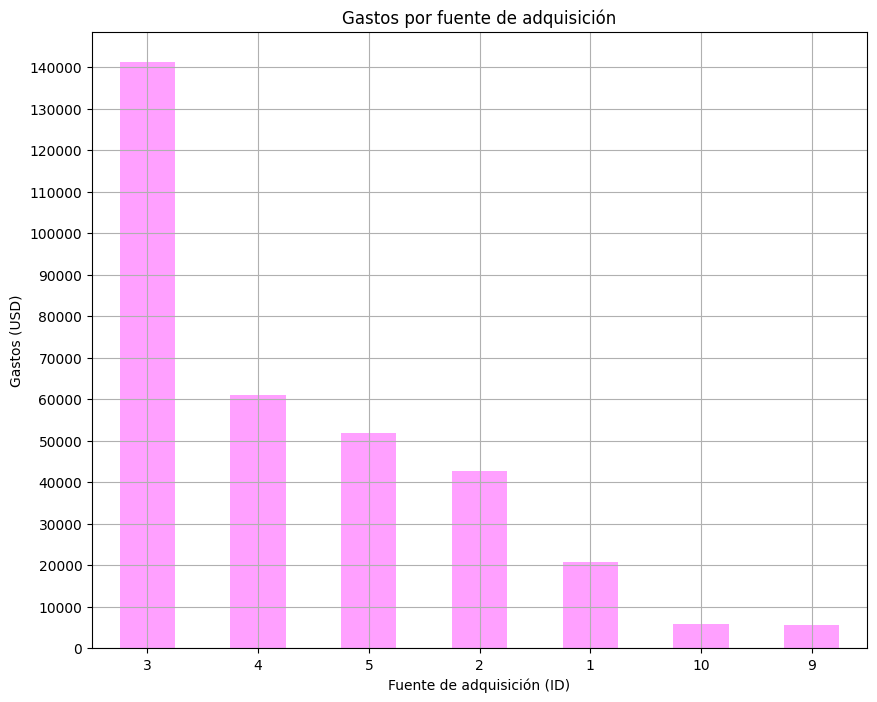

In [45]:
source_costs.plot(
    # x='source_id',
    # y= 'conversion_count',
    kind='bar',
    figsize=[10,8],
    grid=True,
    color = '#FFA0FF',
    yticks = np.linspace(0, 140000, 15),
    title = 'Gastos por fuente de adquisición',
    ylabel = 'Gastos (USD)',
    xlabel = 'Fuente de adquisición (ID)',
    legend = False
    )

# plt.legend()
plt.xticks(rotation= 0)
plt.show()

In [46]:
costs_us['month'] = costs_us['dt'].dt.strftime('%Y-%m')
# costs_us['month'] = pd.to_datetime(costs_us['month'], format="%Y-%m")
# costs_us.head()

In [47]:
# costs_us['month'].unique()

In [48]:
costs_time = costs_us.groupby(['source_id','month'], observed= False).agg({'costs' : 'sum'}).reset_index()
costs_time['month'] = pd.to_datetime(costs_time['month'], format="%Y-%m")
print(costs_time)
# costs_time.info()

   source_id      month    costs
0          1 2017-06-01  1125.61
1          1 2017-07-01  1072.88
2          1 2017-08-01   951.81
3          1 2017-09-01  1502.01
4          1 2017-10-01  2315.75
..       ...        ...      ...
79         9 2018-01-01   547.16
80         9 2018-02-01   551.50
81         9 2018-03-01   480.29
82         9 2018-04-01   373.49
83         9 2018-05-01   362.17

[84 rows x 3 columns]


In [49]:
sources = costs_time['source_id'].unique()#.astype('str')
print(sources)

['1', '10', '2', '3', '4', '5', '9']
Categories (7, object): ['1', '10', '2', '3', '4', '5', '9']


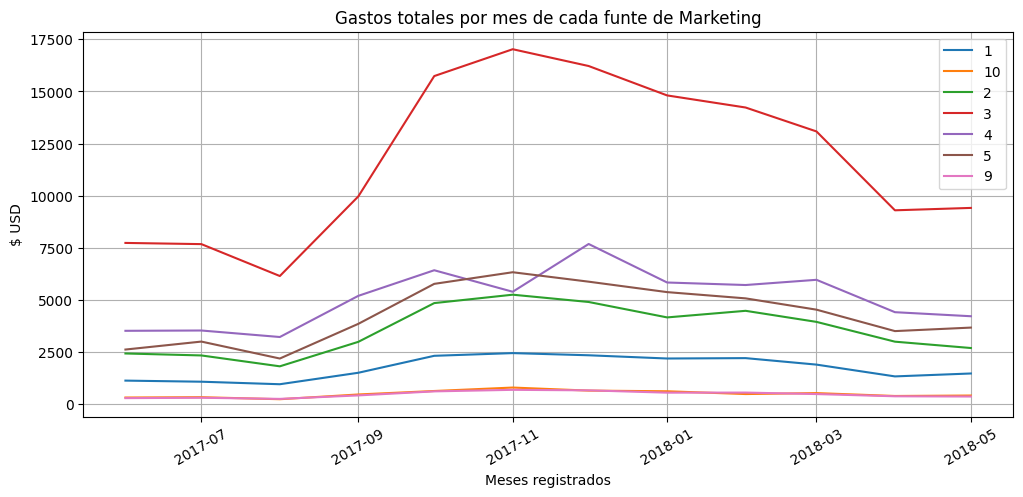

In [50]:
plt.figure(figsize=(12, 5))

for source in sources:
    df = costs_time[costs_time['source_id'] == source][['month', 'costs']]
    # print(f'Gastos por mes de la fuente '+source+' de Marketing\n',df,#df.head(1),
    #       '\n-----------\n'
    #       )
    plt.plot(df['month'], df['costs'], label=str(source))

plt.title('Gastos totales por mes de cada funte de Marketing')
plt.xlabel('Meses registrados')
plt.ylabel('$ USD')
plt.grid(True)
plt.xticks(rotation= 30)
plt.legend(sources)


El análisis de los gastos mensuales de diferentes fuentes de marketing en la empresa revela tendencias y variaciones significativas en la inversión a lo largo del tiempo. Aquí se presentan las conclusiones clave:

1. Comparación de Gastos entre Fuentes de Marketing

    *   Fuente 3: Esta fuente es la que recibe la mayor inversión de marketing, con picos significativos en octubre y noviembre de 2017, superando los 15,000 y 17,000 unidades monetarias respectivamente. Estos altos niveles de gasto sugieren que esta fuente es considerada estratégica para la empresa.

    *   Fuente 2: También se observa una inversión considerable en la fuente 2, especialmente en los últimos meses de 2017 y principios de 2018, con gastos que superan los 5,000 unidades monetarias. Este gasto alto puede reflejar campañas agresivas o estrategias de adquisición clave.

    *   Fuentes 4 y 5: Estas fuentes muestran un gasto moderado, con un incremento significativo hacia finales de 2017 y principios de 2018. Aunque sus picos no alcanzan los niveles de la fuente 3, siguen siendo relevantes para la estrategia de marketing.

    *   Fuentes 1, 9 y 10: Estas fuentes tienen los niveles de gasto más bajos. En particular, la fuente 9 y la fuente 10 muestran inversiones mensuales que rara vez superan las 1,000 unidades monetarias. Esto podría indicar una menor prioridad estratégica o un enfoque en campañas más específicas o de menor escala.

2. Evolución de los Gastos a lo Largo del Tiempo

    *   Tendencia Ascendente en 2017: La mayoría de las fuentes muestran un aumento en los gastos a medida que se avanza en el año 2017, alcanzando picos hacia octubre y noviembre, posiblemente relacionados con campañas de fin de año o temporadas de mayor consumo.

    *   Estabilización en 2018: En el primer trimestre de 2018, se observa una estabilización o ligera disminución en los gastos, lo que puede reflejar un ajuste de las estrategias de marketing o una fase de optimización tras un período de inversión intensa.

3. Consideraciones Estratégicas

    *   Evaluación de Eficiencia: Dado el alto gasto en algunas fuentes (como la fuente 3), sería importante evaluar la eficiencia de estas inversiones en términos de retorno sobre la inversión (ROI) y conversión de usuarios. Las fuentes con menor gasto también deben ser revisadas para asegurarse de que están alcanzando su potencial.

    *   Diversificación de Estrategias: La variabilidad en los gastos sugiere que la empresa está probando diferentes estrategias en varias fuentes de marketing. Esta diversificación es positiva, pero debe estar acompañada de un análisis continuo para redirigir inversiones hacia las fuentes más rentables.

#### Economía unitaria por cliente: CAC

El CAC (costo de adquisición de clientes/as) es el costo de atraer a cada cliente: el dinero que un/a nuevo/a cliente/a le cuesta a una empresa. La economía unitaria por cliente es sólida si el LTV es mayor que el CAC.

$$
LTV > CAC
$$

In [51]:
# costs_us['month'] = pd.to_datetime(costs_us['month'], format="%Y-%m")
# costs_us.info()
# # costs_us.head()

In [52]:
# report.head()
# report.info()

In [53]:
def data_prep(device, visits, orders, costs_us, filter = False):

	# visits.info()
	if filter:
		visits = visits.merge(orders, on= 'uid', how= 'inner')
		
	else:
		visits = orders
		device = 'General'
	#
	visits['order_month'] = pd.to_datetime(visits['buy_ts'], format="%Y-%m").dt.date
	visits['order_month'] = pd.to_datetime(visits['order_month'], format="%Y-%m")
	visits['order_month'] = visits['order_month'].dt.strftime('%Y-%m')
	visits['order_month'] = pd.to_datetime(visits['order_month'], format="%Y-%m")
	#
	if filter:
		visits = visits[visits['device'] == device][['buy_ts','revenue', 'uid', 'order_month']]
		visits = visits.drop_duplicates()
	#
	first_orders = visits.groupby('uid').agg({'order_month': 'min'}).reset_index()
	first_orders.columns = ['uid', 'first_order_month']
	#
	cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
	cohort_sizes.columns = ['first_order_month', 'n_buyers']
	#
	orders_ = pd.merge(visits,first_orders, on='uid')
	#
	cohorts = orders_.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
	#
	report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
	report['first_order_month'] =  pd.to_datetime(report['first_order_month'], format="%Y-%m")
	#
	margin_rate = 0.5
	#
	report['gp'] = report['revenue'] * margin_rate
	report['age'] = (
	    report['order_month'] - report['first_order_month']
	) / np.timedelta64(1, 'D') / 30
	report['age'] = report['age'].round().astype('int')
	#
	report['ltv'] = report['gp'] / report['n_buyers']
	#
	costs_us['month'] = costs_us['dt'].dt.strftime('%Y-%m')
	#
	costs_time = costs_us.groupby(['source_id','month'], observed= False).agg({'costs' : 'sum'}).reset_index()
	costs_time['month'] = pd.to_datetime(costs_time['month'], format="%Y-%m")
	#
	sources = costs_time['source_id'].unique()#.astype('str')
	#
	costs_us['month'] = pd.to_datetime(costs_us['month'], format="%Y-%m")

	return report, costs_time, sources, visits, orders, costs_us, device


In [54]:
def marketing_metrics(costs, source, report, case = 1, pnt = False):
    df = costs[costs['source_id'] == source][['month', 'costs']]
    report_ = report.merge(df, left_on='first_order_month', right_on='month', how='inner')
    report_ = report_.drop_duplicates()
    report_['cac'] = report_['costs'] / report_['n_buyers']
    
    report_['romi'] = report_['ltv'] / report_['cac']
    output = report_.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean')
    if(case == 1):
        if(pnt):
            print(report_)
        return report_
    if( case == 2):
        if(pnt):
            print(output)
        return output

In [55]:
def filter_name(filter = 0):
    if filter == 'desktop':
        return 'Desktop_'
    elif filter == 'touch':
        return 'Touch_'
    else:
        return 'No_filter_'

In [56]:
# rep = marketing_metrics(costs_time,sources[0], 1, True)

In [57]:
# Volvemos a leer los archivos CSV para reiniciar los dataframes para limpiarlos de datos inecesarios
[costs_us, orders, visits] = data_load()

#imprimimos la lista de dispositivos
print(visits['device'].unique(), f'\n\n')

#Configuraciones para la función `data_prep` para aplicar el filtro deseado por dispositivo o no aplicar el filtro
# apply_filter = True
apply_filter = False
# filter_nm = 'desktop'
filter_nm = 'touch'

# llamamos a la función `data_prep` para obtener las variables 
# necesarias y aplicar el filtro a los datos de ordenes para poder 
# calcular las métricas de marketing con la función `marketing_metrics`

[report, costs_time, sources, visits, orders, costs_us, filter_report] = data_prep(filter_nm, visits, orders, costs_us, apply_filter)

# print(visits.head())

# rep = marketing_metrics(costs_time,sources[1], report, 1, True)

['touch', 'desktop']
Categories (2, object): ['desktop', 'touch'] 




In [58]:
for source_ in sources:
    rep = marketing_metrics(costs_time,source_, report, 1, False)
    print(f'Costo de adquisisción de clientes de la fuente ' + source_ + ': ',rep['cac'].sum(), ' USD.')

Costo de adquisisción de clientes de la fuente 1:  45.58782822550814  USD.
Costo de adquisisción de clientes de la fuente 10:  12.81679985851702  USD.
Costo de adquisisción de clientes de la fuente 2:  93.95610707634921  USD.
Costo de adquisisción de clientes de la fuente 3:  309.7303408438805  USD.
Costo de adquisisción de clientes de la fuente 4:  139.4736707525555  USD.
Costo de adquisisción de clientes de la fuente 5:  113.23067070020956  USD.
Costo de adquisisción de clientes de la fuente 9:  12.157186342827467  USD.


El análisis del Costo de Adquisición de Clientes (CAC) revela diferencias sustanciales en la eficiencia de las distintas fuentes de marketing utilizadas por la empresa:

1. Fuentes de Bajo Costo:
    *   Las fuentes 9 y 10 destacan por sus bajos CAC, con $12.16 USD y $12.82 USD respectivamente. Estas fuentes representan las opciones más económicas para adquirir nuevos clientes, lo que podría ser indicativo de una alta eficiencia en estas campañas o estrategias de marketing.

2. Fuentes de Costo Moderado:
    *   La fuente 1 tiene un CAC de $45.59 USD, lo cual es moderado en comparación con otras fuentes. Esta cifra sugiere que, aunque no es la más económica, podría estar obteniendo un balance aceptable entre costo y efectividad.

3. Fuentes de Alto Costo:
    *   Las fuentes 3, 4 y 5 presentan CAC significativamente altos, especialmente la fuente 3 con un CAC de $309.73 USD. La fuente 4 tiene un CAC de $139.47 USD, y la fuente 5 un CAC de $113.23 USD. Estos altos costos de adquisición pueden ser preocupantes, especialmente si no se justifican con un alto valor de vida del cliente (LTV).

4. Estrategia de Optimización:
    *   Dados los altos costos de algunas fuentes, la empresa debería considerar revisar su estrategia de asignación de presupuesto en marketing. Es posible que se deba reducir la inversión en las fuentes más costosas o encontrar maneras de optimizar su rendimiento para mejorar la eficiencia general del gasto en marketing.

#### Economía unitaria por cliente: ROMI

El ROMI (Retorno de la Inversión en Marketing) es una métrica que mide la efectividad de una inversión en marketing al calcular el retorno generado por dicha inversión. Es similar al ROI (Return on Investment), pero específicamente aplicado a las actividades de marketing.

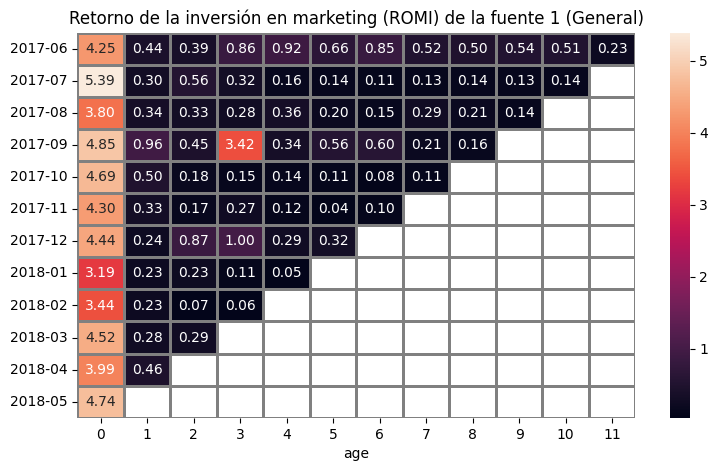

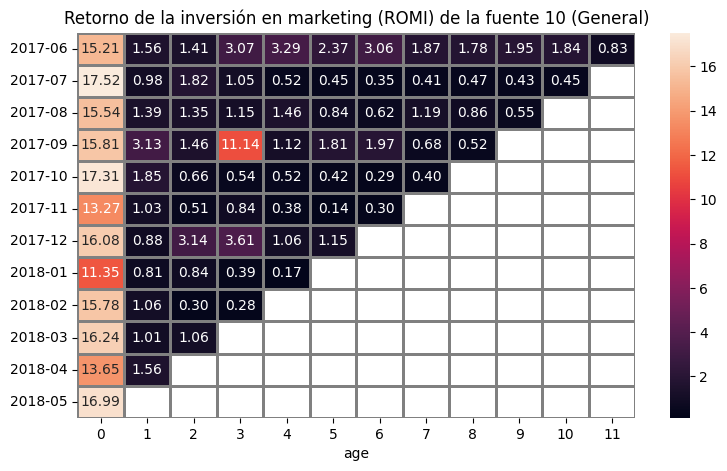

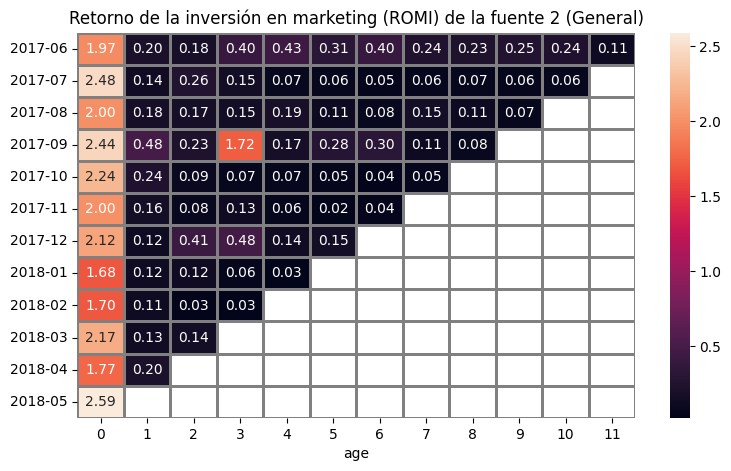

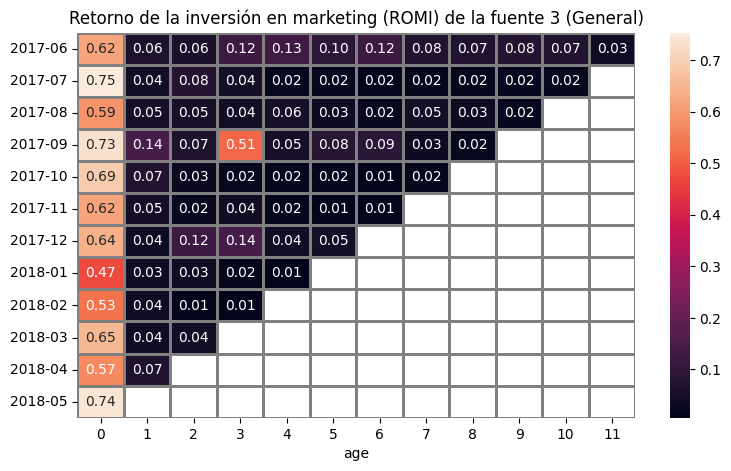

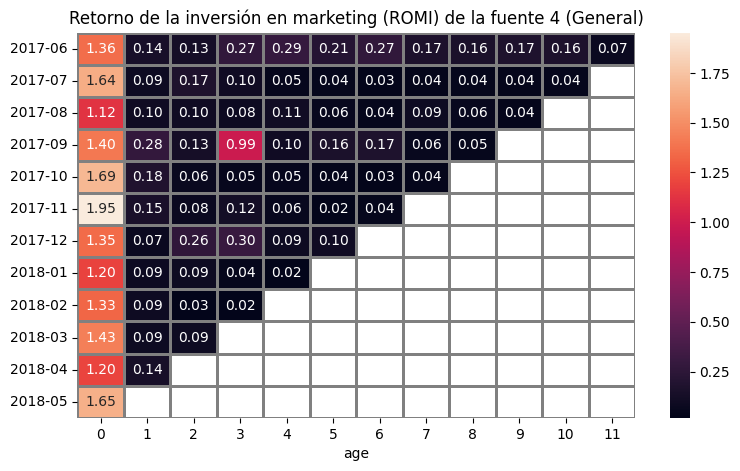

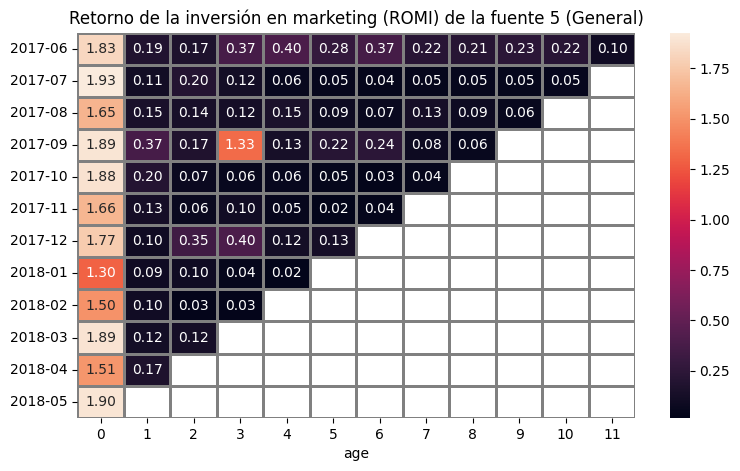

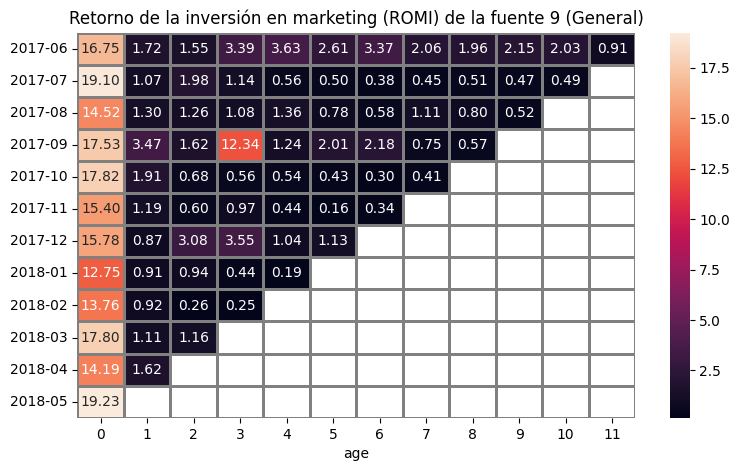

In [59]:
for source_ in sources:
    rep = marketing_metrics(costs_time,source_, report, 2, False)

    rep.index = costs_time['month'].dt.strftime('%Y-%m').unique()

    plt.figure(figsize=(9, 5))
    # plt.title('')
    ax = sns.heatmap(
        rep,
        annot=True,
        fmt='.2f',
        linewidths=1,
        linecolor='gray',
    )

    filename = filter_name(filter_report) + 'heatmap_source_' + str(source_)

    plt.title(('Retorno de la inversión en marketing (ROMI) de la fuente ' + str(source_) + ' (' + filter_report + ')'))

    # print(filename)
    # plt.savefig(f"{filename}.png")

plt.show()

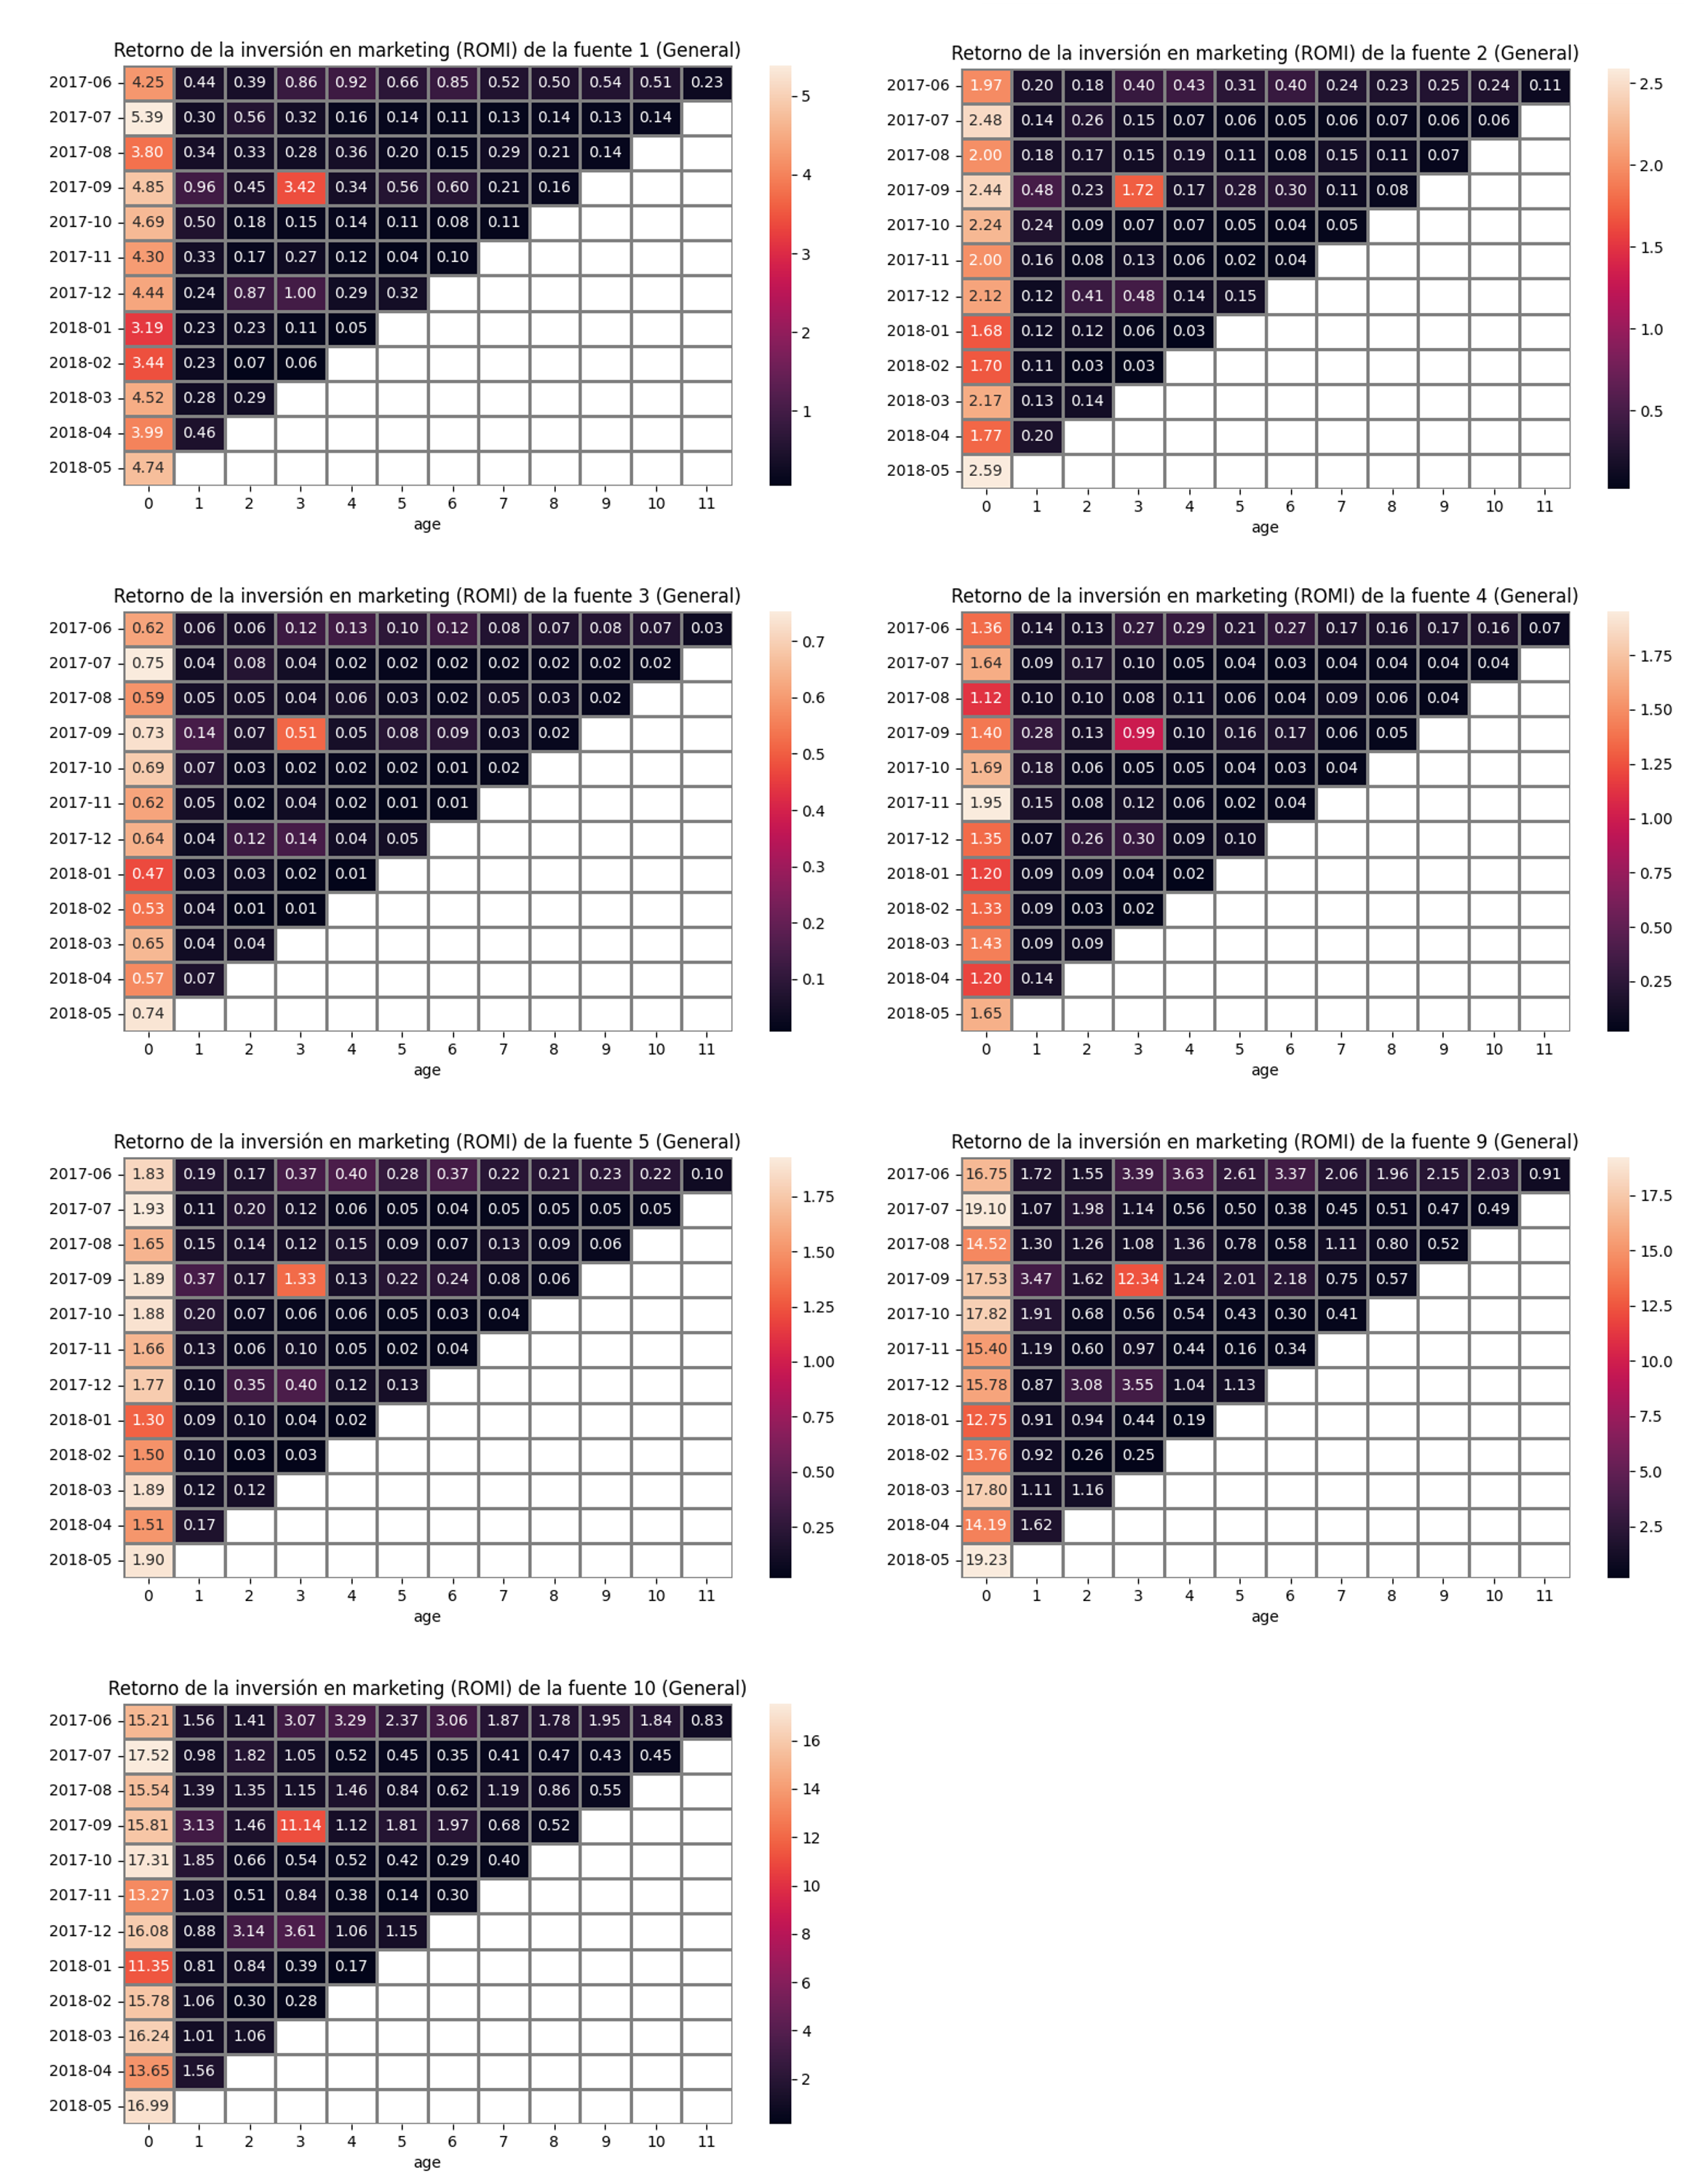

In [60]:
# Ruta al archivo de imagen
img_path = 'General_ROMI_group.png'

# Mostrar la imagen con un tamaño específico
display(Image(filename=img_path, width=1000, height=800))

A partir de la información visualizada en las tablas pivote que muestran el ROMI de diferentes fuentes de marketing, se pueden extraer las siguientes conclusiones:

1. Desempeño Consistente:
    *   La fuente 9 muestra un ROMI consistentemente alto a lo largo del tiempo, especialmente en los primeros meses, alcanzando valores superiores a 16. Esto indica que la inversión en esta fuente es extremadamente rentable en el corto plazo, con un retorno significativo desde el primer mes.

2. Crecimiento Moderado:
    *   Las fuentes 1 y 5 presentan un ROMI moderado que se estabiliza rápidamente. Aunque no alcanzan valores tan altos como la fuente 9, su rentabilidad es aceptable y parece mantener una tendencia positiva, lo que sugiere que pueden ser fuentes confiables de retorno a mediano plazo.

3. Fuentes Menos Eficientes:
    *   Las fuentes 2, 3 y 4 muestran un ROMI bajo o fluctuante en comparación con otras fuentes. En particular, la fuente 3 tiene valores iniciales muy bajos y sólo muestra una ligera mejora en meses posteriores. Esto sugiere que estas fuentes podrían estar generando un retorno insuficiente en relación con la inversión, lo que podría justificar una reevaluación de su efectividad.

4. Tendencias Positivas Tardías:
    *   Aunque algunas fuentes como la fuente 10 empiezan con un ROMI bajo, muestran una mejora significativa con el tiempo, especialmente después del tercer o cuarto mes. Esto indica que estas fuentes pueden requerir un periodo de maduración más largo para que el retorno sobre la inversión sea visible, pero eventualmente pueden ofrecer buenos resultados.

5. Variabilidad en el ROMI:
    *   Existe una notable variabilidad en el ROMI no solo entre diferentes fuentes, sino también en diferentes periodos para la misma fuente. Esto sugiere que el éxito de las campañas de marketing puede depender de múltiples factores, incluyendo estacionalidad, cambios en la estrategia, o fluctuaciones en la demanda del mercado.

6. Recomendaciones:
    *   Optimizar la inversión en fuentes de alto rendimiento como la fuente 9, mientras se reduce o reevalúa la inversión en aquellas con un ROMI bajo, como la fuente 3.
    *   Monitorear las tendencias de fuentes como la fuente 10, que muestran mejoras significativas a lo largo del tiempo, para capitalizar en su rendimiento futuro.
    *   Realizar ajustes estratégicos en las campañas de las fuentes con menor rendimiento para intentar mejorar su ROMI o considerar la redistribución del presupuesto hacia fuentes más eficientes.

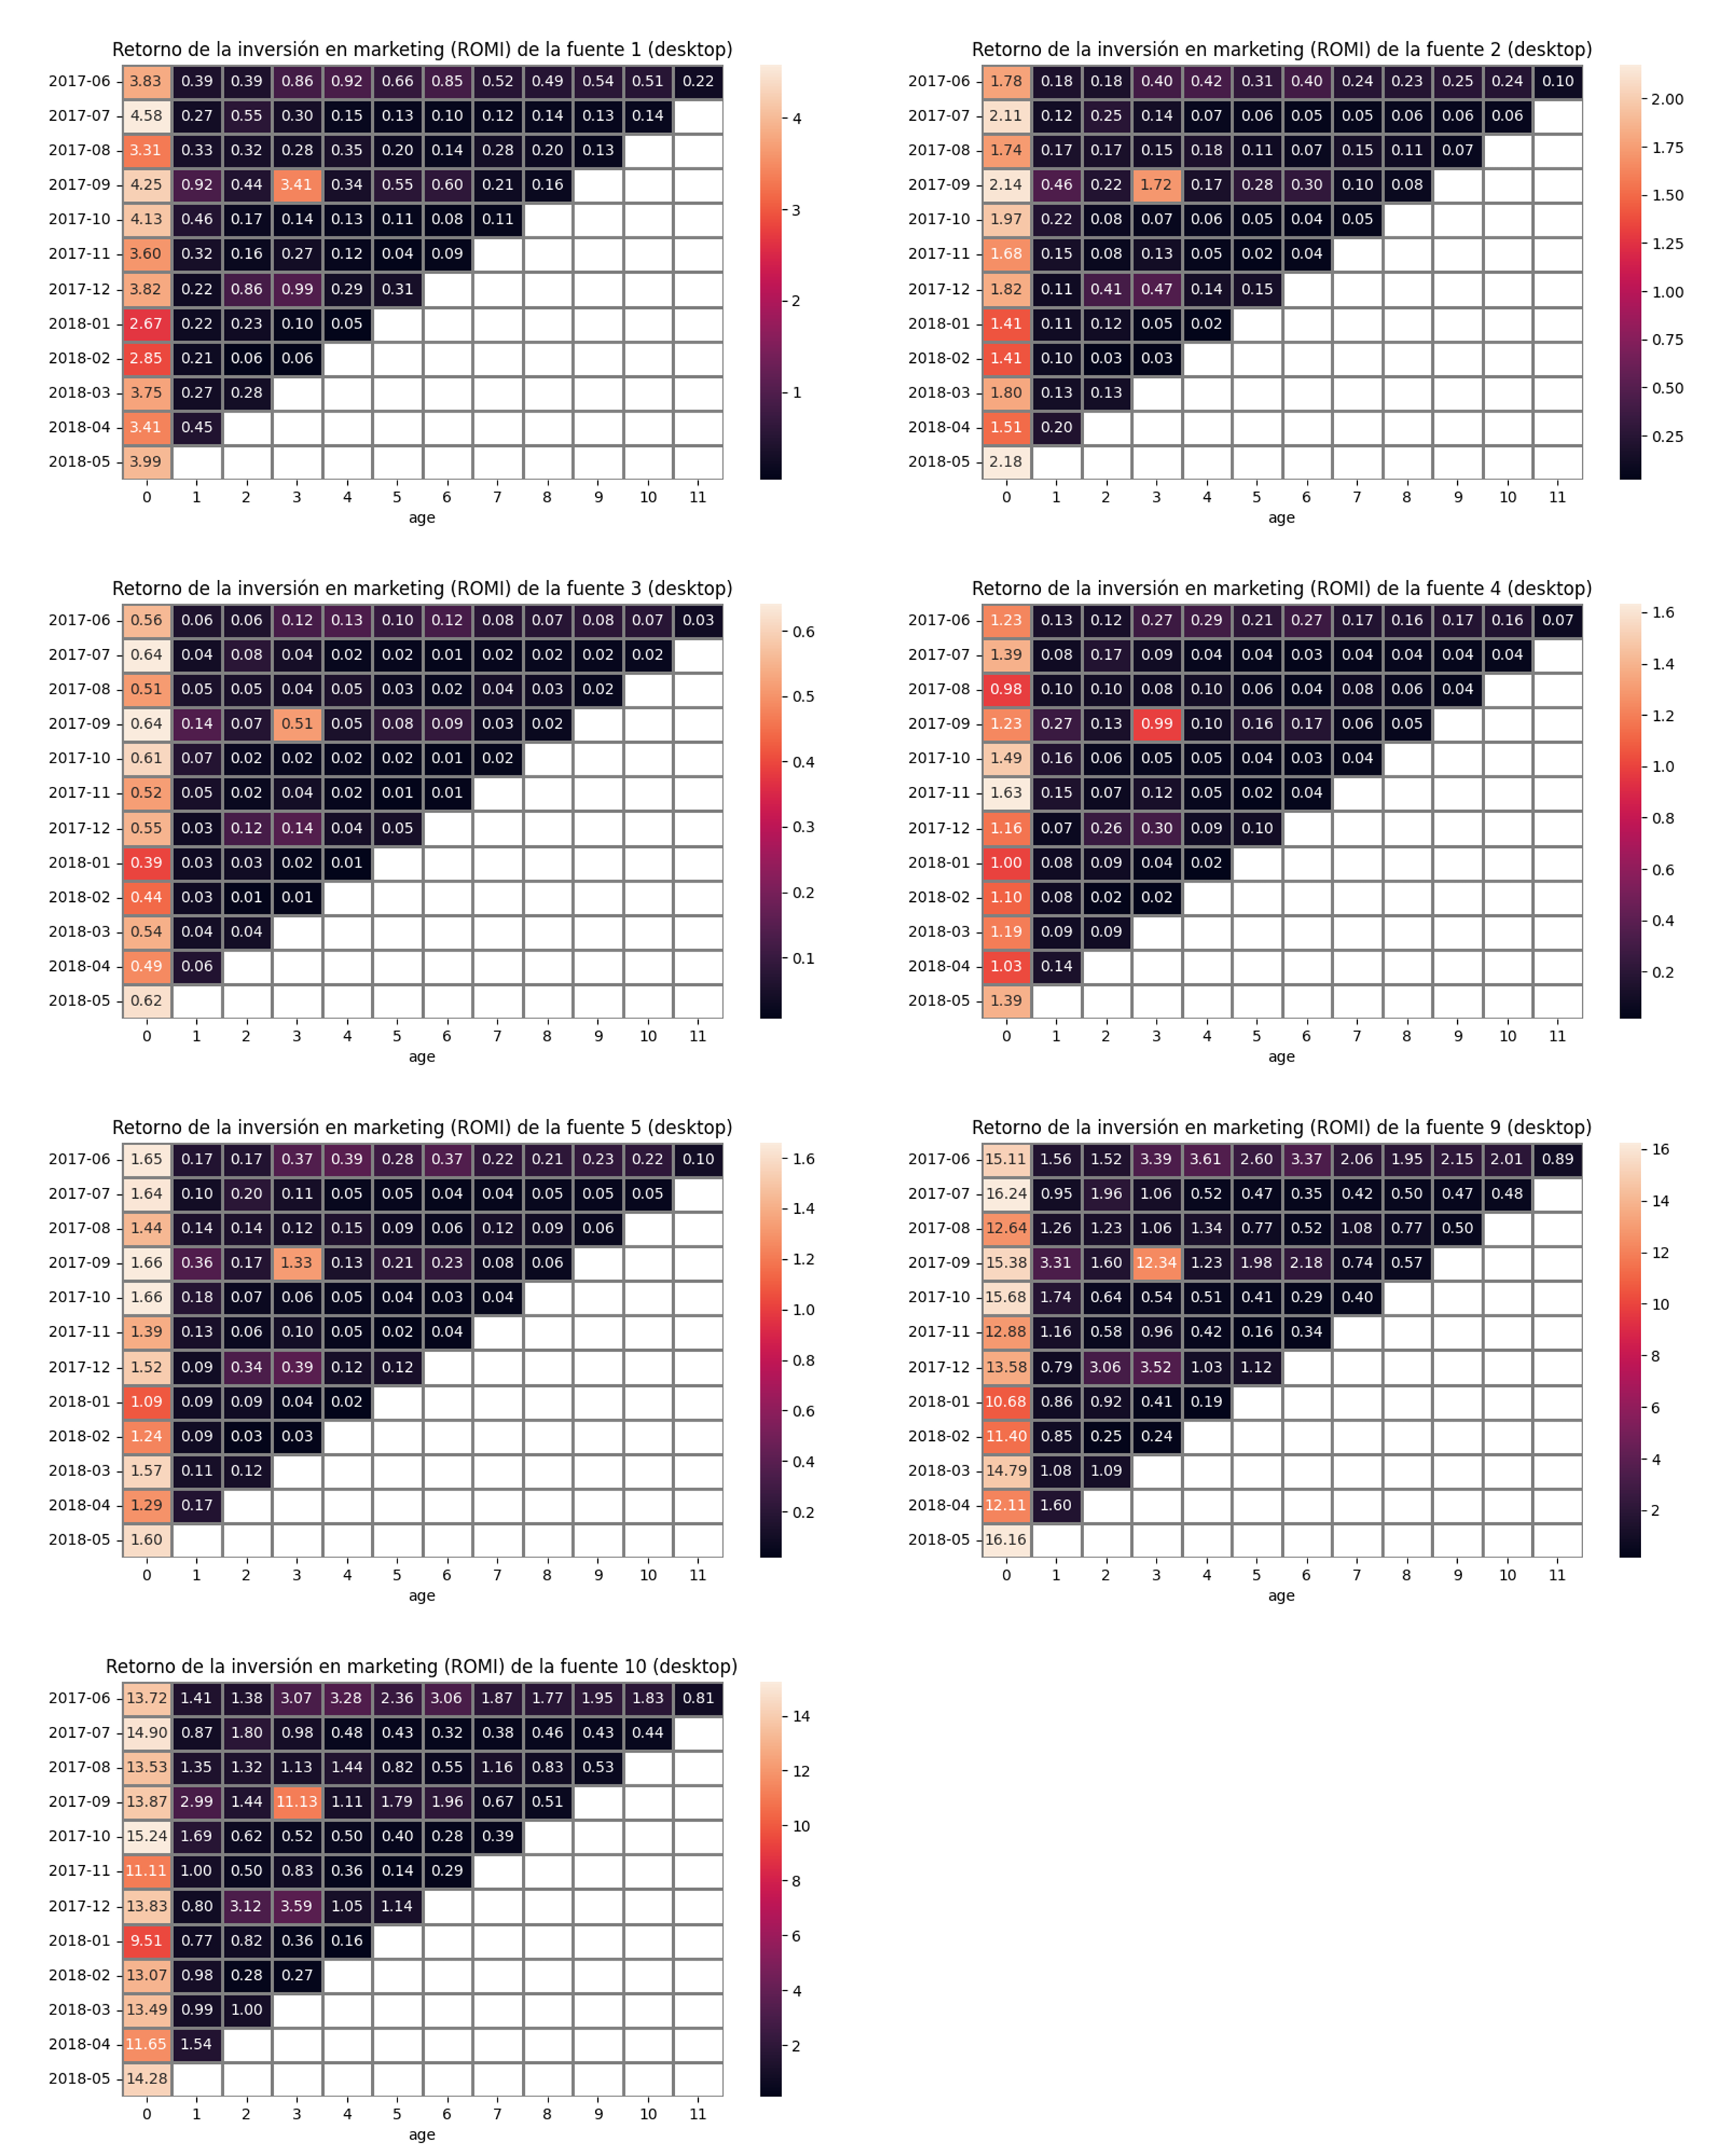

In [61]:
# Ruta al archivo de imagen
img_path = 'Desktop_ROMI_group.png'

# Mostrar la imagen con un tamaño específico
display(Image(filename=img_path, width=1000, height=800))

A partir de la visualización de las tablas pivote que muestran el ROMI de diferentes fuentes de marketing en dispositivos de escritorio (desktop), se pueden extraer las siguientes conclusiones:

1. Desempeño Consistente y Alto Retorno:
    *   La fuente 9 nuevamente destaca con un ROMI muy alto, especialmente en los primeros meses, con valores que superan ampliamente el 15. Esto indica que las campañas en esta fuente son altamente rentables en dispositivos de escritorio, y el retorno es sustancial desde el principio.

2. Crecimiento Gradual:
    *   Las fuentes 1 y 5 presentan un crecimiento gradual en su ROMI, manteniendo valores moderados pero consistentes a lo largo del tiempo. Aunque no alcanzan los niveles de la fuente 9, su comportamiento sugiere una estabilidad y una rentabilidad que puede ser confiable a mediano y largo plazo.

3. Fuentes con Rendimiento Limitado:
    *   Las fuentes 2, 3 y 4 muestran un ROMI bajo en general, con algunas fluctuaciones y pequeñas mejoras en ciertos periodos. Esto sugiere que estas fuentes podrían no estar generando el retorno esperado en la inversión realizada para dispositivos de escritorio, lo que podría justificar una reevaluación de las estrategias aplicadas en estas plataformas.

4. Tendencias Tardías en el ROMI:
    *   La fuente 10 muestra un patrón interesante donde los primeros meses presentan un ROMI bajo, pero después de aproximadamente seis meses, se observa una mejora significativa. Esto indica que las campañas en esta fuente pueden necesitar más tiempo para madurar y comenzar a ofrecer un retorno significativo.

5. Variabilidad en el Retorno:
    *   Existe una alta variabilidad en el ROMI tanto entre diferentes fuentes como en diferentes periodos dentro de la misma fuente. Este patrón sugiere que el rendimiento de las campañas de marketing en dispositivos de escritorio puede estar influenciado por múltiples factores, como la estacionalidad, los cambios en la demanda, o las modificaciones en las estrategias publicitarias.

6. Recomendaciones:
    *   Maximizar la inversión en la fuente 9, ya que consistentemente demuestra ser la más rentable, especialmente en dispositivos de escritorio.
    *   Monitorear y ajustar las campañas en fuentes como la 1 y la 5, que muestran un crecimiento estable y podrían beneficiarse de inversiones adicionales para optimizar aún más su retorno.
    *   Reevaluar la estrategia para las fuentes 2, 3 y 4, dado su bajo rendimiento, con el fin de determinar si es más eficiente redirigir los recursos a fuentes más efectivas o mejorar las campañas actuales.
    *   Aprovechar el potencial de fuentes como la 10 para periodos más largos, ya que, aunque su ROMI inicial es bajo, mejora significativamente con el tiempo.

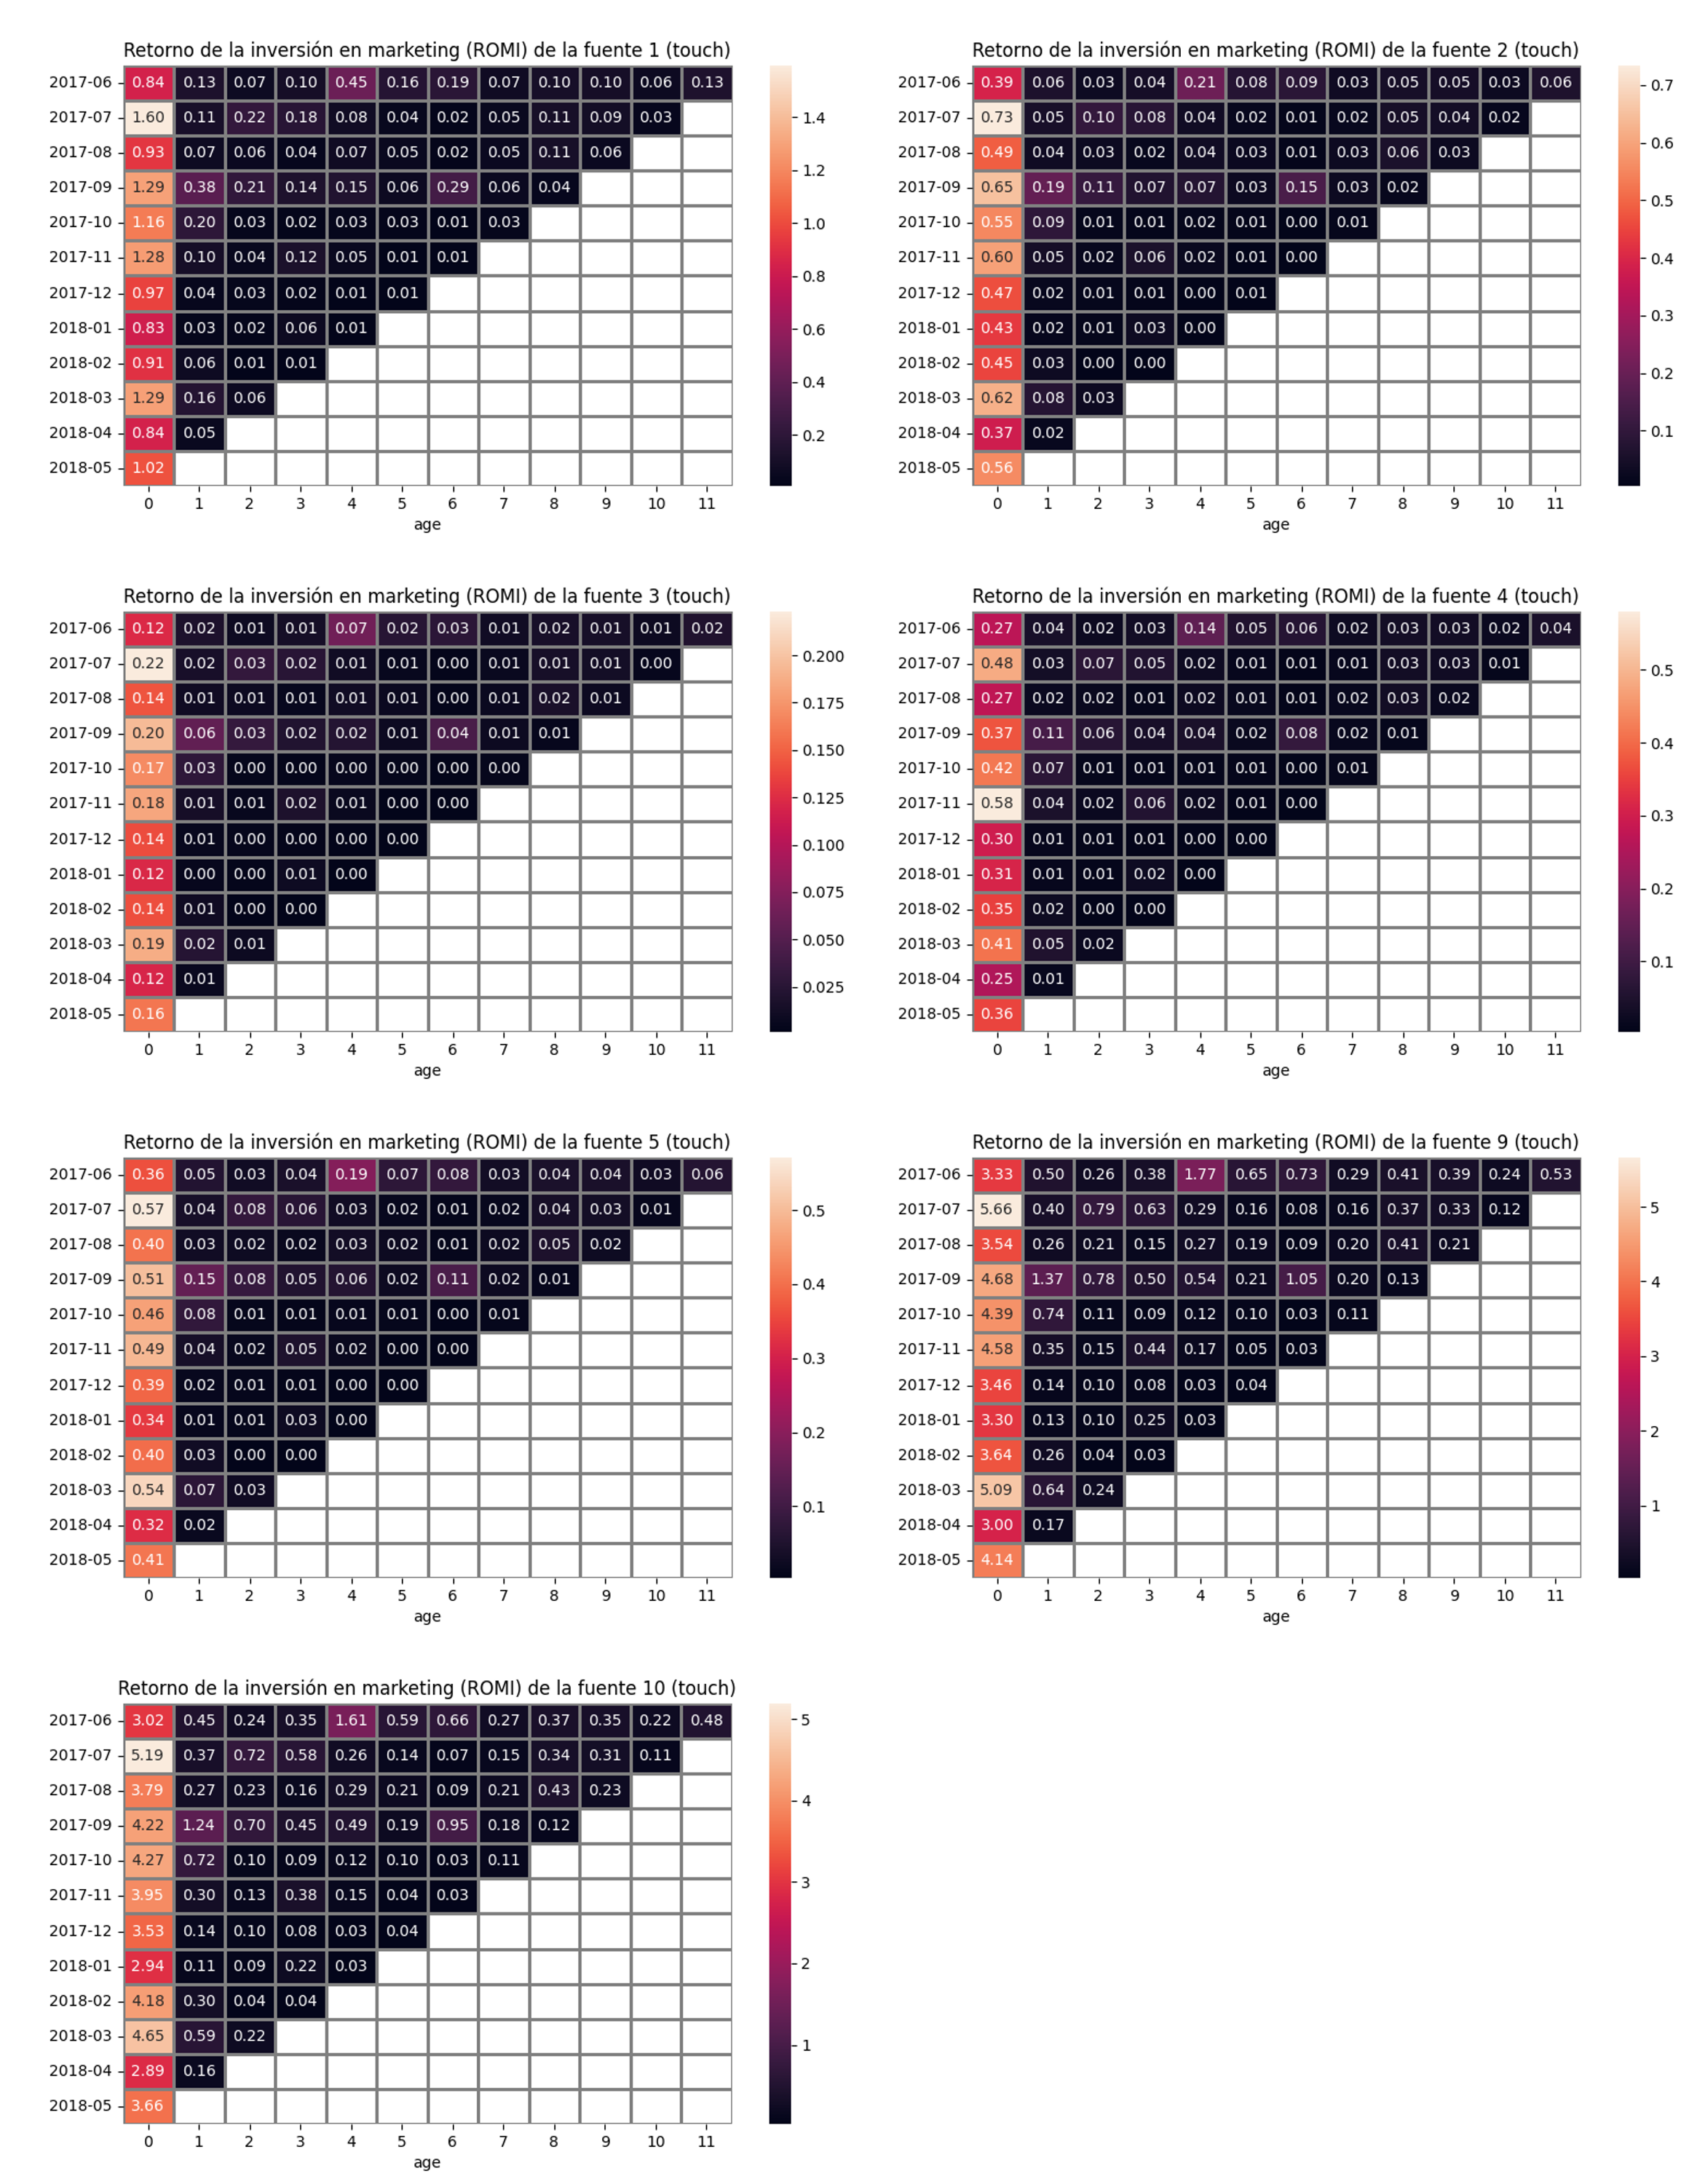

In [62]:
# Ruta al archivo de imagen
img_path = 'Touch_ROMI_group.png'

# Mostrar la imagen con un tamaño específico
display(Image(filename=img_path, width=1000, height=800))

Al analizar las tablas pivote que representan el ROMI de diferentes fuentes de marketing en dispositivos táctiles (touch), se pueden extraer las siguientes conclusiones:

1. Rendimiento Bajo y Negativo en la Mayoría de las Fuentes:
    *   La mayoría de las fuentes, especialmente las fuentes 1, 2, 3, 4 y 5, muestran un ROMI consistentemente bajo e incluso negativo en varios meses. Esto sugiere que las campañas en estas fuentes están generando pérdidas en lugar de beneficios en los dispositivos táctiles, lo que indica un rendimiento subóptimo en estos canales.

2. La Excepción Notable: Fuente 10:
    *   La fuente 10 es una excepción destacada, con un ROMI relativamente alto en comparación con las otras fuentes. Aunque los primeros meses muestran valores más bajos, el ROMI aumenta considerablemente en los meses posteriores, indicando un potencial retorno positivo en dispositivos táctiles para esta fuente.

3. Rendimiento Volátil en la Fuente 9:
    *   La fuente 9 presenta una mezcla de resultados, con algunos periodos de alto ROMI (especialmente en los primeros meses de ciertas cohortes) seguidos de caídas significativas. Esto sugiere una alta volatilidad en el rendimiento de las campañas en esta fuente para dispositivos táctiles.

4. Estancamiento y Declive en el Tiempo:
    *   Un patrón común entre la mayoría de las fuentes es que el ROMI tiende a disminuir o mantenerse estancado con el tiempo, sin mostrar una recuperación significativa. Esto indica que las campañas no logran mejorar su efectividad en dispositivos táctiles a medida que pasa el tiempo, lo que podría ser un signo de saturación del mercado o de ineficiencias en la estrategia de marketing.

5. Comparación con Otros Dispositivos:
    *   En comparación con las métricas de ROMI para desktop y general, el rendimiento en dispositivos táctiles es considerablemente peor. Esto sugiere que las estrategias de marketing que funcionan en otros dispositivos no se traducen bien a los dispositivos táctiles, y podría ser necesario rediseñar las campañas para este segmento específico.

6. Recomendaciones:
    *   Reevaluar y optimizar las campañas en dispositivos táctiles para las fuentes 1, 2, 3, 4 y 5, ya que están generando un retorno negativo o bajo, lo que indica que los recursos pueden estar mejor invertidos en otros canales o en ajustar las estrategias actuales.
    *   Aumentar la inversión en la fuente 10 en dispositivos táctiles, dado su rendimiento relativamente superior, con la posibilidad de obtener un retorno positivo a largo plazo.
    *   Monitorear de cerca la fuente 9 debido a su volatilidad, y considerar estrategias de mitigación de riesgos, como la diversificación o el ajuste de la segmentación, para estabilizar el rendimiento.
    *   Rediseñar las campañas específicamente para dispositivos táctiles, enfocándose en las características únicas de estos dispositivos, como la usabilidad, la experiencia del usuario y los patrones de comportamiento, para intentar mejorar el ROMI en estos canales.

## Conclusiones

En conjunto, las `métricas de actividad de los asuarios` indican una base de usuarios leal y activa que interactúa regularmente con los servicios de la empresa. La estabilidad en las sesiones diarias y la duración promedio de las mismas refleja una experiencia de usuario efectiva. Sin embargo, la empresa podría explorar estrategias para aumentar el número de usuarios que utilizan los servicios de forma diaria, buscando convertir más usuarios semanales y mensuales en usuarios diarios. Esto podría mejorar aún más el compromiso y la retención a largo plazo.

Los datos sugieren que, aunque la empresa tiene un grupo pequeño pero comprometido de usuarios que regresan y realizan compras, hay un área significativa de mejora en la retención general y la conversión de usuarios en clientes recurrentes. Fomentar una mayor retención y mejorar la tasa de compra repetida debería ser una prioridad estratégica. Esto podría implicar mejoras en la experiencia de usuario, comunicación personalizada, incentivos para la repetición de compras, y análisis más profundo de los factores que impulsan el compromiso de los usuarios actuales.

Las fuentes de marketing con alta tasa de conversión deben ser priorizadas en las estrategias de marketing, mientras que las de baja conversión deberían ser revisadas o ajustadas. La mayoría de los usuarios se convierten rápidamente, pero una proporción significativa requiere más tiempo. Implementar estrategias para acelerar el proceso de conversión para los usuarios que tardan más tiempo y mantener el enfoque en las fuentes de marketing más efectivas son pasos clave para mejorar la eficiencia y efectividad en la conversión de usuarios.

En general, la empresa presenta una tendencia de disminución del LTV después del primer mes, con variabilidad significativa entre cohortes. Es crucial que se revisen las estrategias de retención y adquisición de usuarios para maximizar el LTV y asegurar el crecimiento sostenible a largo plazo.

En general, la empresa está invirtiendo fuertemente en ciertas fuentes de marketing, especialmente la fuente 3, mientras que otras fuentes reciben un menor enfoque. La tendencia de gasto ascendente hacia finales de 2017, seguida de una estabilización en 2018, sugiere una fase inicial de inversión intensiva seguida de un ajuste estratégico. Es crucial que la empresa continúe evaluando el rendimiento de estas inversiones para optimizar el uso de los recursos y maximizar los resultados.

La empresa tiene una mezcla de fuentes de marketing con variabilidad en su eficiencia de adquisición de clientes. El enfoque debería estar en optimizar la inversión en fuentes de alto costo y maximizar el retorno de aquellas que ya son más eficientes.

El rendimiento del ROMI varía considerablemente entre las diferentes fuentes de marketing. Algunas fuentes muestran un alto retorno inicial que tiende a disminuir con el tiempo, mientras que otras mantienen un rendimiento más consistente pero con menor retorno general. Esto indica la necesidad de ajustar y monitorear las estrategias de marketing según la fuente para maximizar el retorno.

Las campañas de marketing en dispositivos táctiles presentan un rendimiento generalmente bajo y, en muchos casos, negativo en la mayoría de las fuentes. La fuente 10 es una excepción, con un rendimiento relativamente mejor. Sin embargo, en general, se recomienda reevaluar y optimizar las campañas para mejorar el ROMI en estos dispositivos, ya que los resultados actuales indican ineficiencia y la posibilidad de obtener mejores retornos con un enfoque adaptado.

Este resumen sugiere que las estrategias de adquisición y marketing requieren ajustes específicos según la fuente y el dispositivo para mejorar la eficiencia y maximizar los retornos.